In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [79]:
file = ROOT.TFile.Open("run3K_NE_305stop.root")
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")

In [80]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [81]:
fit_start=30000
fit_stop=305000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [82]:
print(y_cov[0][0])
mat=np.linalg.eigvalsh(y_cov)
for irow in range (0, fit_range):
    if mat[irow]<=0:
        print(irow,"\n")

6.74738907942369e-08


In [83]:
def fit_func(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_2cbo= 0.0,
               phi_2cbo = 0.0,
               asym_vw= 0.0,
               phi_vw = 0.0,
               asym_vbo= 0.0,
               phi_vbo = 0.0,
               A_cbot = 0.0)-> np.double:
    
    
    tau_vw = 85310
    omega_vw = 0.013891
    
    tau_vbo = 15470
    omega_vbo = 0.014094
    
    tau_cbot= 24200
    
    omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))

    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_phi))
    
    N2cbo=(asym_2cbo*exp(-time/(tau_cbo/2))*cos(2*omega_cbot*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/(tau_cbo/2))*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/(tau_cbo/2))*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))


    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo - ff*Ncbof*Nvwf*Nvbof - fb*Ncbob*Nvwb*Nvbob)/(2*f*Ncbo*Nvw*Nvbo + ff*Ncbof*Nvwf*Nvbof + fb*Ncbob*Nvwb*Nvbob)

In [84]:
p_init=[2.28839e-01,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        2.54062e+05,
        2.330e-03,
        5.56481e-01,
        6.91318e-04,
        -5.78075e+00,
        6.39026e-05,
        3.52887e+01,
        2.36536e-04,
        #1.38419e+05,
        #1.389e-02,
        2.73495e-01,
        -1.00112e-03,
        #3.48295e+04,
        #1.407e-02,
        -1.99555e+01,
        1.10668e-04,
        3.06805e+00,
        0.0047]

In [85]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_err)

In [86]:
p_init=pars2

In [87]:
pars_final, cov_final = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [88]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov_final))

In [89]:
for ipar in range(0,26):
    print(pars_final[ipar],"       +-  ",stdevs[ipar],"  \n")

0.22931559724729572        +-   3.08125733030522e-05   

-35.15364587337898        +-   1.704364013064452   

4.003500158022421        +-   0.0002595403166751463   

0.0017568368393163624        +-   9.272150453480153e-05   

212112.87800536572        +-   29951.195264206304   

0.0023285553727154904        +-   1.5640820565595274e-06   

-0.613324820503506        +-   0.2149804191153285   

0.0005008110789179184        +-   0.0002766700401055663   

-6.610118528065531        +-   0.5901445711043178   

-4.359949180920687e-05        +-   0.00027738423669362795   

33.96321964948103        +-   6.465790671534875   

-9.733100218463136e-05        +-   6.094244915592288e-05   

-0.39176617968580957        +-   0.7564982720752758   

0.0002751339663825957        +-   5.9611280489962524e-05   

-19.592378628643583        +-   0.2160396427275513   

-0.004933209623368522        +-   0.0005144211137375772   

6.374538590869705        +-   0.10370972908445884   

-0.0033309347333075265        

IndexError: index 18 is out of bounds for axis 0 with size 18

In [90]:
pars_final

array([ 2.29315597e-01, -3.51536459e+01,  4.00350016e+00,  1.75683684e-03,
        2.12112878e+05,  2.32855537e-03, -6.13324821e-01,  5.00811079e-04,
       -6.61011853e+00, -4.35994918e-05,  3.39632196e+01, -9.73310022e-05,
       -3.91766180e-01,  2.75133966e-04, -1.95923786e+01, -4.93320962e-03,
        6.37453859e+00, -3.33093473e-03])

In [91]:
stdevs

array([3.08125733e-05, 1.70436401e+00, 2.59540317e-04, 9.27215045e-05,
       2.99511953e+04, 1.56408206e-06, 2.14980419e-01, 2.76670040e-04,
       5.90144571e-01, 2.77384237e-04, 6.46579067e+00, 6.09424492e-05,
       7.56498272e-01, 5.96112805e-05, 2.16039643e-01, 5.14421114e-04,
       1.03709729e-01, 9.50769105e-03])

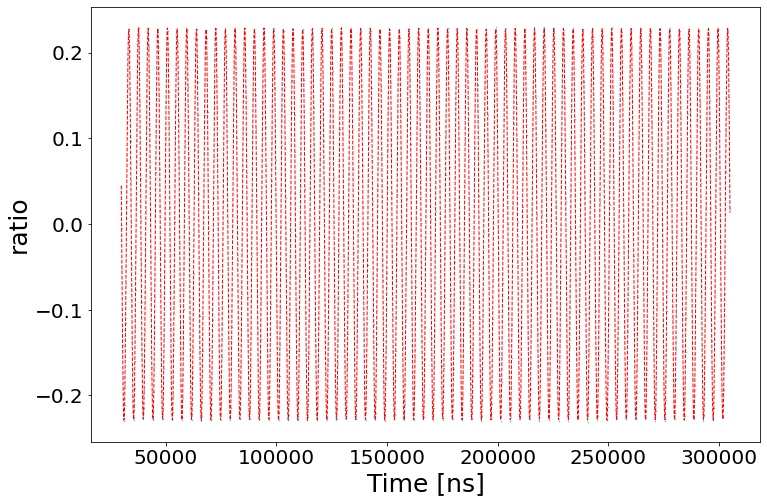

In [92]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.scatter(x_val, y_val, s=0.1, color='#00b3b3', label='Data')
plt.plot(x_val, fit_func(x_val, *pars_final), linestyle='--', linewidth=1, color='red')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('ratio',fontsize=25)
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [93]:
# Calculate the residuals
res = (y_val - fit_func(x_val, *pars_final))/y_err

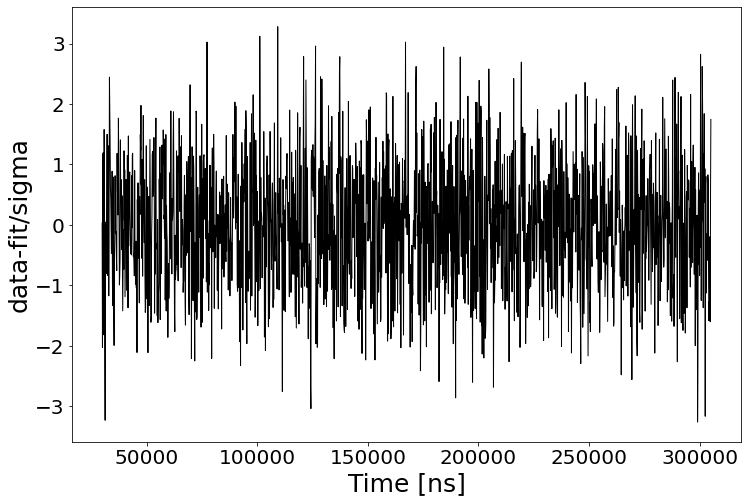

In [94]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(x_val, res, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('data-fit/sigma',fontsize=25)
plt.savefig('run2all_res.jpg')

In [95]:
stdevs

array([3.08125733e-05, 1.70436401e+00, 2.59540317e-04, 9.27215045e-05,
       2.99511953e+04, 1.56408206e-06, 2.14980419e-01, 2.76670040e-04,
       5.90144571e-01, 2.77384237e-04, 6.46579067e+00, 6.09424492e-05,
       7.56498272e-01, 5.96112805e-05, 2.16039643e-01, 5.14421114e-04,
       1.03709729e-01, 9.50769105e-03])

In [96]:
fou=abs(np.fft.fft(res))

In [97]:
#xfft=np.empty(fit_range)
xfft= np.linspace(0,6.667,num=fit_range)
xfft[800]

2.9081788440567067

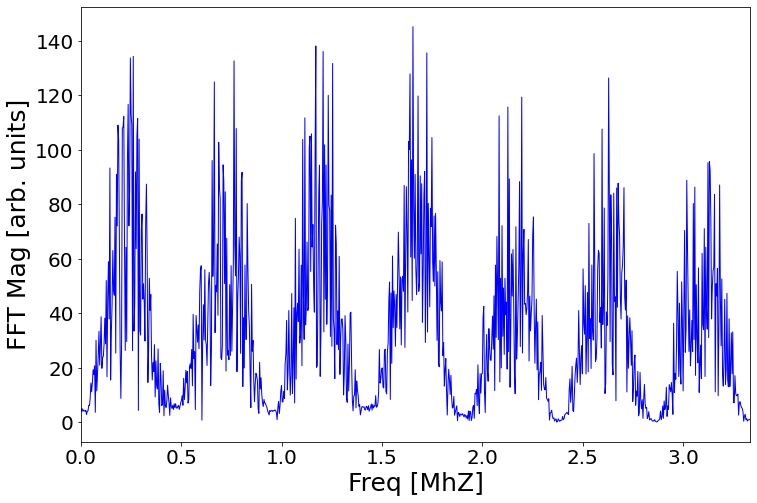

In [98]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(xfft, fou, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=25)
plt.ylabel('FFT Mag [arb. units]',fontsize=25)
plt.savefig('run2all_fft.jpg')

In [99]:
chi2=np.dot((np.transpose(y_val-fit_func(x_val, *pars_final))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func(x_val, *pars_final)))))

In [100]:
chi2

1728.7753628049961

In [101]:
ndf=fit_range-len(pars_final)

In [102]:
red_chi2=chi2/ndf

In [103]:
red_chi2

0.9514448887204161

In [104]:
ndf

1817